In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # For customizing the suabplots spacing
import pandas as pd
import os

In [2]:
from sklearn.decomposition import FastICA
import scipy
import scipy.signal as scsig

In [3]:
from synchronization import Synchronizer

## Steps for synchronization
- (0) Load the metadata (Versuchstabelle) -> to identify the file names (soundbook, QASS)
- (1) Load the synchro signals 
    - Dewetron
    - IDMT data, ch3 
- (2) Interpolate the Dewetron signal (to compensate the different sampling rate)
    - (2-0) ICA to increase the SNR
    - (2-1) Linear interpolation
- (3) Cross-correlate the interpolated Dewetron signal and the IDMT data
- (4) Identify the delay (i.e. peak)

## (0) Load the meta data (Versuchstabelle) -> for file names

In [4]:
path_meta = '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/00_Versuchsplan_iHub.xlsx'
metadf = pd.read_excel(
    path_meta,
    sheet_name=1,
    usecols="B:F",
    nrows=71
)

## Example

In [5]:
# Path to the data
path_dew = '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/01_DEWETRON_csv'
path_idmt = '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/03_Soundbook'

# Example trial
dataID = 14
row = dataID - 1
fname_dew = metadf['DEWETRON'][row]
fname_idmt = metadf['SoundBook'][row]
fname_izfp = metadf['QASS'][row]

## Load the synch signals

In [6]:
#---- Synchronize
synch = Synchronizer()
# (1) Load
# IDMT data
t_idmt, s_idmt = synch.load_hd5(path_idmt, fname_idmt) # zero-meaned and normalized
# Dewetron data
t_dew, s_dew = synch.load_dew(path_dew, fname_dew)
# Zero-mean and normalize
s_dew = s_dew - np.mean(s_dew)
s_dew = s_dew/np.abs(s_dew).max()
    

## (1) Synchronization by downsampling the SoundBook signal

### Check the frequency response of the SoundBook synchsignal

In [ ]:
# Check the frequency spectra
#%matplotlib widget
#%matplotlib inline

fig = plt.figure(figsize=(7, 9), layout='constrained')
axs = fig.subplot_mosaic([
    ["signal", "signal"],
    ["magnitude", "log_magnitude"],
    ["phase", "angle"]
])
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.loc'] = 'upper right'

plt.suptitle(f'SoundBook synch signal: trial = {fname_dew}')

# plot IDMT synch signal
axs["signal"].set_title(f'Signal {fname_dew}')
axs["signal"].plot(t_idmt, s_idmt, color='C0')
axs["signal"].set_xlabel("Time (s)")
axs["signal"].set_ylabel("Amplitude")

# plot different spectrum types:
axs["magnitude"].set_title("Magnitude Spectrum")
axs["magnitude"].magnitude_spectrum(s_dew, Fs=synch.fs_dew, color='C0', label='DEW')
axs["magnitude"].magnitude_spectrum(s_idmt, Fs=synch.fs_idmt, color='C1', alpha=0.7, label='SoundBook')

axs["log_magnitude"].set_title("Log. Magnitude Spectrum")
axs["log_magnitude"].magnitude_spectrum(s_dew, Fs=synch.fs_dew, color='C0', label='DEW', scale='dB')
axs["log_magnitude"].magnitude_spectrum(s_idmt, Fs=synch.fs_idmt, color='C1', alpha=0.7, label='SoundBook', scale='dB')

axs["phase"].set_title("Phase Spectrum ")
axs["phase"].phase_spectrum(s_dew, Fs=synch.fs_dew, color='C0', label='DEW')
axs["phase"].phase_spectrum(s_idmt, Fs=synch.fs_idmt, color='C1', alpha=0.7, label='SoundBook')

axs["angle"].set_title("Angle Spectrum")
axs["angle"].angle_spectrum(s_dew, Fs=synch.fs_dew, color='C0', label='DEW')
axs["angle"].angle_spectrum(s_idmt, Fs=synch.fs_idmt, color='C1', alpha=0.7, label='SoundBook')

#fig.legend(labels=['DEW', 'QASS'])
plt.show()

## Downsampling + Remarks
* Downsampling is done in the frequency domain
    * (1) Low-passed to avoid aliasing
        * Butterworth, cut-off = 5kHz = 0.5* fs of Dewetron
    * (2) Resampled via scipy.signal.resample (frequency domain resampling)
* Low-passed SoudBook synchsignal seems to have peaks in slightly different time points than in the original signal
    * shown as a green signal in Figure (b)
    * huge peak-form differences 
* Downsampled SoundBook synchsignal
    * Peaks seem to occur little earlier than the original? 
    * -> may be critical for determining the delay?
* Interpolated Dewetron synch signal seems okay-ish 
    * It is just noisy as the original
    * but, I used the linear interpolator, so probably not very accurate
    * question is, how critical the inaccuracy here is? 

In [14]:
s_ds_idmt, t_ds_idmt, fs_ds_idmt = synch.downsample(
    s=s_idmt, 
    t=t_idmt, 
    fs=synch.fs_idmt, 
    ret_signal_only=False
)

## Cross-correlation to determine the delay

In [15]:
# !!! Don't forget to trip the Dewetron signal to T_synch (i.e. 1s)
N = int(synch.T_synch* synch.fs_dew)

delay, N_offset, corr, tau = synch.identify_delay(s_dew[:N], s_ds_idmt, fs=synch.fs_dew, ret_corr=True)

Synchronizer: returning the correlation results


In [16]:
delay

0.0252

## Plot

In [ ]:
# Correct the delay and overlap the signals 
#%matplotlib widget
%matplotlib inline

def save_allplots(save, fname=None):

    # Subplots spacing
    plt.rcParams["figure.figsize"] = [6.50, 4.50]
    plt.rcParams["figure.autolayout"] = True
    gs1 = gridspec.GridSpec(3, 1)
    gs1.update(wspace=0.0, hspace=0.15)

    # Axis labels
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=False)
    #plt.suptitle(f'Delay correction of {fname_dew}: {round(delay*10**3, 3)}ms delay')
    plt.subplots_adjust(hspace=0.6) # more spacing between rows

    # Before
    ax0.plot(t_dew, s_dew, label='DEW')
    ax0.plot(t_idmt, s_idmt, label='SB')
    ax0.set_xlabel('Aufnahmezeit [s]')
    ax0.set_ylabel('[V]')
    ax0.legend(loc='upper right')
    ax0.grid(True)
    ax0.set_xlim(-0.5, 2.5)

    # After
    ax1.sharex(ax0)
    ax1.plot(t_dew, s_dew, label='DEW')
    #ax1.plot(t_idmt-delay, s_idmt, label= f'SB-ds')
    ax1.plot(t_ds_idmt-delay, s_ds_idmt, label= f'SB-ds')
    ax1.set_xlabel('Aufnahmezeit [s]')
    ax1.set_ylabel('[V]')
    ax1.legend(loc='upper right')
    ax1.grid(True)

    # Cross-correlation results
    _corr = corr/np.abs(corr).max()
    ax2.plot(tau, _corr, label='cross correlation')
    peaks = delay
    ax2.vlines(x=peaks, ymin=_corr.min(), ymax=_corr.max(), linestyles='--', color='r')
    ax2.set_xlabel('Versatz [s]')
    ax2.set_ylabel(r"[$V^2$]")
    #ax2.legend(loc='upper right')
    xticks = np.sort(np.concatenate((np.array([peaks]), np.array([-1.0, 1.0, 2.0, 3.0, 4.0]))))
    ax2.set_xticks(xticks)
    ax2.grid(True)

    if save == True:
        # Parameters for savefig
        # dpi > 150 does not yield any perceptible difference in resolution 
        # bbox_inches: bounding box to determine the area to be saved => use 'tight', otherwise including a weird white space
        # pad_inches: margine to be padded, if bbox_inches == 'tight'
        plt.savefig(
            fname, 
            dpi=250, 
            bbox_inches = 'tight', 
            pad_inches = 0.1 #pad_inches = 0.05
        ) 

    plt.show()
    

In [ ]:
plt.close('all')
save_allplots(save=False, fname='plots/SoundBook_synchronization.png')

## (2) Determine the delays for all trials via downsampling
**info**:<br>
* 27, 28, 29 -> no pre and post in the dewetron!

In [55]:
# Path to the data
path_dew = '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/01_DEWETRON_csv'
path_idmt = '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/03_Soundbook'
# Base
info_dict = {
    'dataID' : [],
    'DEWETRON': [],
    'SoundBook': [],
    'delay[s]': []
}

for dataID in [27, 28, 29]: #np.arange(1, 27), np.arange(30, len(metadf)+1)
    #---- Specify the name
    row = dataID - 1
    fname_dew = metadf['DEWETRON'][row]
    fname_idmt = metadf['SoundBook'][row]
    print(f'dataID = {dataID}, name = {fname_dew}')
    
    #---- Synchronize
    synch = Synchronizer()
    # Load the Dewetron data 
    t_dew, s_dew = synch.load_dew(path_dew, fname_dew)
    # Load the IDMT data
    t_idmt, s_idmt = synch.load_hd5(path_idmt, fname_idmt)
    # Downsample 
    s_ds_idmt = synch.downsample(s=s_idmt, t=t_idmt, fs=synch.fs_idmt)
    
    # Identify the delay
    # !!! Don't forget to trip the Dewetron signal to T_synch (i.e. 1s)
    N = int(synch.T_synch* synch.fs_dew)
    delay, N_offset = synch.identify_delay(s_dew[:N], s_ds_idmt, fs=synch.fs_dew)
    
    #-------------
    # -> for the trials without pre- and post-triger (27, 28, 29) => use noisy dewetron signal
    # Dewetron data
    # t_dew, s_dew = synch.load_dew(path_dew, fname_dew)
    # # Zero-mean and normalize
    # s_dew = s_dew - np.mean(s_dew)
    # s_dew = s_dew/np.abs(s_dew).max()
    # s_ica = s_dew[:synch.N+1]
    # t_interp, s_interp = synch.interpolate(t_dew, s_ica, t_idmt[int(1.0*synch.fs_idmt)+1:], synch.fs_idmt)
    # # Identify the delay
    # delay, N_offset = synch.identify_delay(s_interp, s_idmt, synch.fs_idmt)
    #-------------
    
    #---- Update the info dictionary
    info_dict['dataID'].append(dataID)
    info_dict['DEWETRON'].append(fname_dew)
    info_dict['SoundBook'].append(fname_idmt)
    info_dict['delay[s]'].append(delay)
    

dataID = 27, name = 27_0_1_Spalt_pneu
dataID = 28, name = 28_0_1_Spalt_pneu
dataID = 29, name = 29_0_1_Spalt_pneu


In [58]:
# Convert the dictionary to a dataframe
info_df = pd.DataFrame.from_dict(info_dict, orient='columns')
# Print
info_df

,dataID,DEWETRON,SoundBook,delay[s]
0,27,27_0_1_Spalt_pneu,iHub2023_030,0.0263
1,28,28_0_1_Spalt_pneu,iHub2023_031,0.0263
2,29,29_0_1_Spalt_pneu,iHub2023_032,0.0253


In [50]:
info_df1 = info_df.copy() # dataID: 1 ... 26

In [31]:
info_df2 = info_df.copy() # dataID: 30 ... last

In [59]:
info_df3 = info_df.copy() # dataID: 27, 28, 29

In [61]:
complete_df = pd.concat((info_df1, info_df3, info_df2), ignore_index=True)

In [63]:
complete_df

,dataID,DEWETRON,SoundBook,delay[s]
0,1,01_0_1_Spalt_pneu,iHub2023_001,0.0157
1,2,02_0_1_Spalt_pneu,iHub2023_002,0.0244
2,3,03_0_1_Spalt_pneu,iHub2023_003,0.0260
3,4,04_0_1_Spalt_pneu,iHub2023_004,0.0267
4,5,05_0_1_Spalt_pneu,iHub2023_005,0.0267
...,...,...,...,...
66,67,67_0_2_Spalt_pneu_CJ_X2,iHub2023_075,0.0283
67,68,68_0_2_Spalt_pneu_CJ_X2,iHub2023_076,0.0259
68,69,69_0_2_Spalt_pneu_CJ_X2,iHub2023_077,0.0170
69,70,70_0_2_Spalt_pneu_CJ_X2,iHub2023_078,0.0289


In [64]:
# Save the dataframe as csv
path2save = '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/04_Delays'
complete_df.to_csv(f'{path2save}/delays_SoundBook_downsampled.csv', index=False)

### Statstics

In [65]:
print('Mean:')
print(complete_df['delay[s]'].mean())
print('Std:')
print(complete_df['delay[s]'].std())

Mean:
0.030795774647887332
Std:
0.056733500903333046


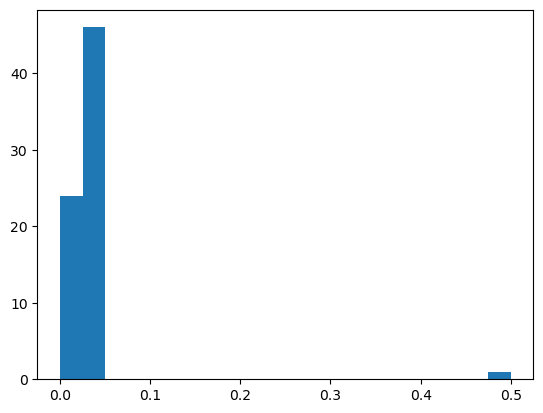

In [70]:
plt.figure()
plt.hist(np.array(complete_df['delay[s]']), bins=20)
plt.show()

In [72]:
print('Outlier:')
print(complete_df['DEWETRON'][63])
print(complete_df['delay[s]'][63])

Outlier:
64_0_2_Spalt_pneu_CJ_X1
0.5


In [73]:
# Exclude the outlier
new_df = complete_df.drop(index=63)
# Average delay without the outlier
print('Mean without the outlier')
print(new_df['delay[s]'].mean())
print('Std without the outlier')
print(new_df['delay[s]'].std())

Mean without the outlier
0.02409285714285714
Std without the outlier
0.005398156460098379
